<a href=https://colab.research.google.com/github/williampayne23/pytorch-notebooks/blob/main/Transformer.ipynb target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer
Working from [this](https://github.com/jacobhilton/deep_learning_curriculum/blob/master/1-Transformers.md)

## Initial Questions

1. What is different architecturally from the Transformer, vs a normal RNN, like an LSTM? (Specifically, how are recurrence and time managed?) 
    
    No recurrance, time uses positional embeddings, self attention.

2. Attention is defined as, $\text{Attention}(Q,K,V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V$. What are the dimensions for Q, K, and V? Why do we use this setup? What other combinations could we do with (Q,K) that also output weights?

  $\text{seq_length} \times d_k, d_k, d_v$

  So $QK^T$ is a $(\text{seq_length}, \text{seq_length})$ matrix and Attention is a $(\text{seq_length}, d_v)$ matrix
  
  But MultiHead attention is defined as
  
  $\text{MultiHeadAttention}(Q, K, V) = \text{concat}(\text{head}_1, \text{head}_2, \ldots)W_0$
  
  These heads are defined as
  
  $\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^Q)$
  
  Where
  
  $W_i^Q \in \mathbb{R}^{d_\text{model}\times d_k}, W_i^K \in \mathbb{R}^{d_\text{model}\times d_k} , W_i^V \in \mathbb{R}^{d_\text{model}\times d_v}$ and $W_O \in \mathbb{R}^{hd_v\times d_\text{model}}$.
  
  This means working backward that for multi headed attention
  
  $Q, K, \text{and } V \in \mathbb{R}^{\text{seq_length} \times d_\text{model}}$
  
  and
  
  $\text{concat}(\text{head}_1, \text{head}_2, \ldots) \in \mathbb{R}^{\text{seq_length} \times hd_\text{dv}}$ 
  
  so
  
  $\text{MultiHeadAttention}(Q, K, V) \in \mathbb{R}^{\text{seq_length} \times d_\text{model}}$
  
  It seems like in a lot of implementations there is just one W^Q matrix which is all the W_i^Q matrices concatinated together so $W^Q \in \mathbb{R}^{d_\text{model} \times hd_k}$ which means $W^Q \in \mathbb{R}^{d_\text{model} \times d_\text{model}}$
  
  You then have to split it up again for the Attention function (since the creation of self attn (softmax($QK^T$)) is the part that we get independently

3. Are the dense layers different at each multi-head attention block? Why or why not?

    Yes, so the different blocks can encode different relationships / focusses in attention

4. Why do we have so many skip connections, especially connecting the input of an attention function to the output? Intuitively, what if we didn't?
    The original word embedding might get buried under noise if it isn't reinforced. 
    
    From solution:
        In the ResNet paper, it was observed that some deep neural networks perform worse than their shallow counterparts. Adding skip connections empirically seemed to solve this issue. The intuition is that adding skip connections allows layers to learn the identity mapping more easily. "To the extreme, if an identity mapping were optimal, it would be easier to push the residual to zero than to fit an identity mapping by a stack of nonlinear layers."

    If we didn't include these skip connections, we might experience a degradation of performance for very deep transformer models due to vanishing / exploding gradient problems.
    

## Implementation

In [16]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
import math, copy
from collections import OrderedDict
from tqdm import tqdm

### Implement the positional embeddings function first

Equations

$PE(pos,2i) = \sin(pos/10000^{2i/d_{model}})$

$PE(pos,2i + 1) = \cos(pos/10000^{2i/d_{model}})$

In [17]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEmbedding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        torch.zeros(d_model)
        
        encodings = torch.zeros(max_len, d_model)
        dimensions = torch.arange(d_model)
        denominator = div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        positions = torch.arange(max_len).unsqueeze(1)
        encodings[:,0::2] = torch.sin(positions * denominator)
        encodings[:,1::2] = torch.cos(positions * denominator)
        self.register_buffer('encodings', encodings) #Registers a persistent buffer for this layer
        
    def forward(self, x):
        #x; batch_size, seq_length, d_model
        x = x + self.encodings[:x.size(-2)]
        return self.dropout(x)
    

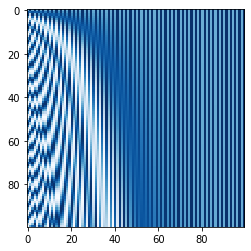

In [18]:
pe = PositionalEmbedding(100, 0)
y = pe.forward(torch.zeros(2, 100, 100))
plt.imshow(y[0], cmap='Blues', interpolation='nearest')
plt.show()

### Then implement the function which calculates attention, given (Q,K,V) as arguments.

In [19]:
torch.tensor([[1,2,3],[4,5,6]]).transpose(0, 1)

tensor([[1, 4],
        [2, 5],
        [3, 6]])

In [20]:
def attention(Q, K, V, mask=None, dropout=None):
    #Q, K, V; batch_size, h, seq_length, dk or dv
    rt_d_k = math.sqrt(Q.size(-1))
    scores = torch.matmul(Q, K.transpose(-1,-2)) / rt_d_k
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -math.inf)
        
    p_att = scores.softmax(dim=-1)
    size = V.size()
    if dropout is not None:
        p_att = dropout(p_att)
    
    return torch.matmul(p_att, V), p_att

### Now implement the masking function.

In [21]:
def masked_attention(Q, K, V):
    print(mask)
    return attention(Q, K, V, mask=mask)

### Put it all together to form an entire attention block.

In [22]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, d_model, dropout=0.1, h = 8, mask=None):
        super(MultiHeadedAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.h = h
        self.dk = d_model // h
        self.dv = self.dk
        self.attn = None
        self.mask = mask
        self.WQ = nn.Linear(d_model, d_model)
        self.WK = nn.Linear(d_model, d_model)
        self.WV = nn.Linear(d_model, d_model)
        self.W0 = nn.Linear(d_model, d_model)
        
    
    def forward(self, x, mask=None):
        # x; batch_size, seq_length, d_model
        batch_size = x.size(0)
        
        #Linearly project X into Q, K, and V
        queries = self.WQ(x) #batch_size, seq_length, d_model
        keys = self.WK(x)    #batch_size, seq_length, d_model
        values = self.WV(x)  #batch_size, seq_length, d_model
        
        #Split Q, K, and V into multi headed
        queries = queries.view(batch_size, -1, self.h, self.dk).transpose(1,2)
        keys = keys.view(batch_size, -1, self.h, self.dk).transpose(1,2)
        values = values.view(batch_size, -1, self.h, self.dv).transpose(1,2)
        
        #q,k,v ; batch_size, h, seq_length, (dk or dv)
        
        x, self.attn = attention(queries, keys, values, mask, self.dropout)
        #x; batch_size, h, seq_length, dk
        #self.attn; batch_size, 
        
        x = x.transpose(1,2).contiguous().view(batch_size, -1, self.dk * self.h)
        #x; batch_size, seq_length, model_size
        
        return self.W0(x)

### Finish the whole architecture.

#### Decoder Block

In [23]:
class FeedForwardNetwork(nn.Module):
    def __init__(self, d_model, d_ff=2048, dropout=0.1):
        super(FeedForwardNetwork, self).__init__()
        self.seq = nn.Sequential(nn.Linear(d_model, d_ff),
                                 nn.ReLU(), 
                                 nn.Dropout(dropout),
                                 nn.Linear(d_ff, d_model))
    
    def forward(self, x):
        return self.seq(x)

In [24]:
class AddAndNorm(nn.Module):
    def __init__(self, size):
        super(AddAndNorm, self).__init__()
        self.norm = nn.LayerNorm(size)
    
    def forward(self, x, layer):
        return self.norm(x + layer(x))

In [25]:
class DecoderBlock(nn.Module):
    def __init__(self, d_model, hidden_layers=2048, dropout=0.1, h=8):
        super(DecoderBlock, self).__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.mha = MultiHeadedAttention(d_model, dropout, h)
        self.ffn = FeedForwardNetwork(d_model, hidden_layers, dropout)
        
        
    def forward(self, x, mask=None):
        base_mask = torch.tril(torch.ones(x.size(-2), x.size(-2))).to(x.device)
        if mask is not None:
            base_mask = mask*base_mask
        x = self.ln1(x + self.mha(x, base_mask))
        x = self.ln2(x + self.ffn(x))
        return x

#### Decoder Stack

In [26]:
class DecoderStack(nn.Module):
    def __init__(self, d_model, N=8, hidden_layers=2048, dropout=0.1, h=8):
        super(DecoderStack, self).__init__()
        self.decoder_blocks = nn.ModuleList([copy.deepcopy(DecoderBlock(d_model, hidden_layers, dropout, h)) for x in range(N)])
    
    def forward(self, x, mask=None):
        for block in self.decoder_blocks:
            x = block(x, mask)
        return x

#### Decoder only transformer
Learned Embeddings -> +Positional embeddings -> Decoder Block (*N) -> Linear -> Softmax -> Output probabilities

In [27]:
class DecoderTransformer(nn.Module):
    def __init__(self, d_model, vocab, N=8, d_ffl=2048, dropout=0.1, h=8, max_len=5000):
        super(DecoderTransformer, self).__init__()
        assert d_model % h == 0
        self.learned_embeddings = nn.Embedding(vocab, d_model)
        self.positional_embedding = PositionalEmbedding(d_model, dropout=dropout, max_len=max_len)
        self.decoder_stack = DecoderStack(d_model, N=N, hidden_layers=d_ffl, dropout=dropout, h=h)
        self.lin = nn.Linear(d_model, vocab)
    
    
    def forward(self, x, mask=None):
        #x; batch_size, seq_length, vocab_len
        embedding = self.learned_embeddings(x) #batch_size, seq_length, d_model
        pos_embedding = self.positional_embedding(embedding) #batch_size, seq_length, d_model
        final_embedding = self.decoder_stack(pos_embedding) #batch_size, seq_length, d_model
        logits = self.lin(final_embedding) #.softmax(dim=-1) #batch_size, seq_length, vocab_len
        return logits

### Training on the reverse dataset

In [13]:
class ReverseDataset(Dataset):
    def __init__(self, length):
        self.length = length
        self.size = 10**length # total number of possible combinations

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        x = torch.randint(10, size=(self.length,), dtype=torch.long)
        y = torch.flip(x,(-1,))
        return x, y

In [14]:
rd = ReverseDataset(6)

batch_size = 2048
train_loader = DataLoader(
    rd, shuffle=True, pin_memory=True, batch_size=batch_size
)
device =torch.device("mps" if torch.backends.mps.is_available() and torch.backends.mps.is_built() else "cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


#### Functional optimiser

In [15]:
model = DecoderTransformer(
  d_model=128, 
  vocab=10, 
  N=2,
  d_ffl=512, 
  dropout=0.1, 
  h=4
).to(device).train()

def train(model):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    max_epochs = 1
    losses = [];
    for epoch in range(max_epochs):
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for it, (x, y) in pbar:
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            logits = model(x)
            loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
            loss.backward()
            losses.append(loss.cpu().detach().numpy())

            optimizer.step()
            pbar.set_description(f"epoch {epoch} iter {it}: train loss {loss.item():.5f}")

In [16]:
torch.device("cuda" if torch.cuda.is_available() else "cpu")

device(type='cuda')

#### Wrapper optimiser

In [138]:
class DecoderTransformerWrapper():
    def __init__(self, model, vocab):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.decoder_transformer = model.to(self.device)
        self.losses = []
        self.vocab = vocab

    @classmethod
    def from_parameters(cls, d_model, vocab, d_ffl=None, height=4, heads=8, dropout=0.1, max_len=5000):
        #vocab should be a list of allowed values
        if d_ffl is None:
            d_ffl = d_model * 4
        model = DecoderTransformer(
          d_model=d_model, 
          vocab=len(vocab), 
          N=height,
          d_ffl=d_ffl, 
          dropout=dropout, 
          h=heads,
          max_len=max_len
        )
        return cls(model, vocab)

    def train(self, train_loader, lr=1e-4, max_epochs=1, loss_fn=nn.CrossEntropyLoss(), test_lambda=None):
        self.decoder_transformer.train()
        optimizer = optim.Adam(self.decoder_transformer.parameters(), lr=lr)
        self.losses = []
        for epoch in range(max_epochs):
            pbar = tqdm(enumerate(train_loader), total=len(train_loader))
            for it, (x, y) in pbar:
                x = x.to(self.device)
                y = y.to(self.device)

                optimizer.zero_grad()

                logits = self.decoder_transformer(x)
                loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
                loss.backward()
                self.losses.append(loss.cpu().detach().numpy())

                pred = logits.argmax(dim=-1)
                if test_lambda is None:
                    correct = (pred == y).type(torch.float).sum().item()
                else:
                    correct = test_lambda(pred, y).type(torch.float).sum().item()
                accuracy = correct / x.size(0)
                optimizer.step()
                pbar.set_description(f"epoch {epoch} iter {it}: train loss {loss.item():.5f}, accuracy {accuracy*100:0.2f}%")
  
    def test(self, test_loader, test_lambda=None):
        self.decoder_transformer.eval()
        correct = 0
        n = 0
        with torch.no_grad():
            pbar = tqdm(enumerate(test_loader), total=len(test_loader))
            for it, (x, y) in pbar:
                x = x.to(self.device)
                y = y.to(self.device)
                n += x.size(0)
                logits = self.decoder_transformer(x)
                pred = logits.argmax(dim=-1)
                if test_lambda is None:
                    correct += (pred == y).type(torch.float).sum().item()
                else:
                    correct += test_lambda(pred, y).type(torch.float).sum().item()
                accuracy = correct / n
                pbar.set_description(f"iter {it}: test accuracy {accuracy*100:.2f}%")    
    
    def eval(self, x):
        self.decoder_transformer.eval()
        x = x.to(self.device)
        if len(x.size()) == 1:
            x = x.unsqueeze(0)
        with torch.no_grad():
            logits = self.decoder_transformer(x)
        return logits
    
    def top_k_logits(self, logits, k):
        v, ix = torch.topk(logits, k)
        out = logits.clone()
        out[out < v[:, [-1]]] = -float('Inf')
        return out

    def sample(self, x, k=1):
        logits = self.eval(x)[0]
        logits = self.top_k_logits(logits, k)
        # apply softmax to convert to probabilities
        probs = logits.softmax(dim=-1)
        # sample from the distribution or take the most likely
        ix = torch.multinomial(probs, num_samples=1)
        return([self.vocab[i.item()] for i in ix])

    def to(self, device):
        self.device = device
        self.decoder_transformer.to(device)


if 'handler' in locals():
    handler = DecoderTransformerWrapper(handler.decoder_transformer, range(10))

In [18]:
handler = DecoderTransformerWrapper.from_parameters(d_model=128,
                                    vocab=range(10),
                                    height=2,
                                    d_ffl=512, 
                                    dropout=0.1, 
                                    heads=4)
# handler.train(train_loader, test_lambda=lambda pred, y: (pred == y)[:, -3:].all(dim=-1))

In [19]:
test_loader = DataLoader(
    rd, shuffle=True, pin_memory=True, batch_size=1024
)
# handler.test(test_loader, test_lambda=lambda pred, y: (pred == y)[:, -3:].all(dim=-1))

### Works of Shakespeare

In [20]:
# DON'T run this the text should be saved
# url = "https://www.gutenberg.org/files/100/100-0.txt"

# import requests
# response = requests.get(url)
# open("works.txt", "wb").write(response.content)

In [30]:
import re
class PlaywriteDataset(Dataset):
  def __init__(self, chunk_size):
    text = open("works.txt", "r").read()
    self.data = re.split(r"\b", text)
    self.vocab = sorted(set(self.data))
    self.chunk_size = chunk_size
    self.size = len(self.data)
    self.vocab_size = len(self.vocab)
    self.index_to_word = {i: word for i, word in enumerate(self.vocab)}
    self.word_to_index = {word: i for i, word in enumerate(self.vocab)}
  
  def __len__(self):
    return self.size - self.chunk_size

  def __getitem__(self, idx):
    #Copying the example I get x and y where y is one word offset from x
    chunk = self.data[idx:idx+self.chunk_size + 1]
    numerical_chunk = [self.word_to_index[word] for word in chunk]
    x = torch.tensor(numerical_chunk[:-1], dtype=torch.long)
    y = torch.tensor(numerical_chunk[1:], dtype=torch.long)
    return x, y

In [31]:
pd = PlaywriteDataset(64)

In [23]:
pd[0]

(tensor([34542,  9992,   113,  8237,   113,  5523,   113, 17830,   113, 24979,
           113,  9992,   113,  3477,   113, 10995,   113, 24979,   113, 10916,
           113,  9165,   480, 14228,   113, 10916,   113,  9165,     1, 10039,
           113, 17830,   113, 22293,   113, 19582,   113, 31392,   113, 33037,
           113, 24979,   113, 12315,   113, 12317,   113, 21768,   113, 31392,
           113, 10403,   113,  9566,   113, 12244,     0, 24317,   113, 25174,
           113, 25577,   113, 24979]),
 tensor([ 9992,   113,  8237,   113,  5523,   113, 17830,   113, 24979,   113,
          9992,   113,  3477,   113, 10995,   113, 24979,   113, 10916,   113,
          9165,   480, 14228,   113, 10916,   113,  9165,     1, 10039,   113,
         17830,   113, 22293,   113, 19582,   113, 31392,   113, 33037,   113,
         24979,   113, 12315,   113, 12317,   113, 21768,   113, 31392,   113,
         10403,   113,  9566,   113, 12244,     0, 24317,   113, 25174,   113,
         2557

In [24]:
word_loader = DataLoader(
    pd, shuffle=True, pin_memory=True, batch_size=64
)

In [139]:
word_handler = DecoderTransformerWrapper.from_parameters(d_model=512,
                                    vocab=pd.index_to_word,
                                    height=8,
                                    d_ffl=2048, 
                                    dropout=0.1, 
                                    heads=8,
                                    max_len=pd.chunk_size)
# word_handler.train(word_loader, test_lambda=lambda pred, y: (pred == y)[:, -3:].all(dim=-1))

In [26]:
word_handler.train(word_loader, test_lambda=lambda pred, y: (pred == y)[b:, -3:].all(dim=-1))

epoch 0 iter 17956: train loss 1.60100, accuracy 21.88%:  58%|█████▊    | 17957/31058 [54:04<39:00,  5.60it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

epoch 0 iter 29175: train loss 1.05205, accuracy 40.62%:  94%|█████████▍| 29176/31058 [1:27:51<05:44,  5.46it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

epoch 0 iter 31057: train loss 0.94542, accuracy 40.00%: 100%|██████████| 31058/31058 [1:33:31<00:00,  5.53it/s]


In [28]:
torch.save(word_handler.decoder_transformer.state_dict(), "test")

In [140]:
word_handler.decoder_transformer.load_state_dict(torch.load("test"))

<All keys matched successfully>

In [62]:
x, y = pd[1001]
def pretty_print_vocab(v):
  print("".join(list(map(lambda x: pd.index_to_word[x],v.tolist()))))

pretty_print_vocab(x)

so gazed on now,
Will be a tattered weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within 


In [63]:
pretty_print_vocab(y)

 gazed on now,
Will be a tattered weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine


In [101]:
def top_k_logits(logits, k):
    v, ix = torch.topk(logits, k)
    out = logits.clone()
    out[out < v[:, [-1]]] = -float('Inf')
    return out

@torch.no_grad()
def sample(model, x, steps, temperature=1.0, sample=False, top_k=None):
    """
    take a conditioning sequence of indices in x (of shape (b,t)) and predict the next token in
    the sequence, feeding the predictions back into the model each time
    """
    model.eval()
    for k in range(steps):
        x_cond = x if x.size(1) <= 64 else x[:, -64:] # crop context if needed
        logits = model(x_cond)
        # pluck the logits at the final step and scale by temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop probabilities to only the top k options
        if top_k is not None:
            logits = top_k_logits(logits, top_k)
        # apply softmax to convert to probabilities
        probs = logits.softmax(dim=-1)
        # sample from the distribution or take the most likely
        if sample:
            ix = torch.multinomial(probs, num_samples=1)
        else:
            _, ix = torch.topk(probs, k=1, dim=-1)
        # append to the sequence and continue
        x = torch.cat((x, ix), dim=1)

    return x

In [131]:
context = " SCENE "
x = torch.tensor([pd.word_to_index[s] for s in re.split(r"\b", context)], dtype=torch.long)[None,...].to(word_handler.device)
y = sample(word_handler.decoder_transformer, x, 500, temperature=1.0, sample=True, top_k=1)[0]
completion = ''.join([pd.index_to_word[int(i)] for i in y])
print(completion)

 SCENE I. Rome. A street

Enter a company of mutinous citizens, with staves, clubs, and other
weapons

  FIRST CITIZEN. Before we proceed any further, hear me speak.
  ALL. Speak, speak.
  FIRST CITIZEN. YOU are all resolv'd.
  THIRD CITIZEN. We are ever true of him.
  THIRD CITIZEN. And so did I; and there is no great need of danger.
    If he were living, I would die to heaven.
    You would not do me good on a living prince,
    But I should live to be your father in love.
  SILVIA. O Eglamour, thou art a gentleman-
    Think not I flatter, for my sake so much
    As I have ever been my father in Rome;
    And never shall he have thy land a living child.
    The day shall be a last, and the last night shall lie,
    And the last hour that ever I shall see thee.
    O, let me kiss my sovereign, and entreat me.
  QUEEN MARGARET. Nay, stay not, but kill me too soon.
    No longer stay longer longer to stay all the town
    Till I have learnt thy head for this world.
  QUEEN MARGARET. H

In [123]:
def in_vocab(word):
  return word in word_handler.vocab.values()

in_vocab("hark")

True

In [143]:
context = " SCENE "
x = torch.tensor([pd.word_to_index[s] for s in re.split(r"\b", context)], dtype=torch.long)[None,...].to(word_handler.device)
word_handler.sample(x)[-1]

'I'